In [1]:
__depends__ = [
    "../data/sr15_scenarios/sr15_scenarios.csv",
    "utils_openscm.py",
    "utils_config.py",
    "utils_plotting.py",
]
__dest__ = [
    "../figures/temp_feedback_switch_sensitivity.eps",
]

Cell above is scons stuff to make sure our dependency tree work. We put a renaming in the cell below to make it clearer what is what.

In [2]:
SCENARIO_PATH = __depends__[0]
TEMP_FEEDBACK_SWITCH_SENSITIVITY_FIG = __dest__[0]

# Carbon cycle temperature feedback switch

In this notebook we perform a couple of runs to see how sensitive MAGICC is to the value of the temperature feedback switch, which controls when the carbon cycle starts to respond to the effect of the temperature feedback.

## Imports

In [3]:
import os
import datetime as dt
from distutils.util import strtobool

from openscm.scmdataframe import ScmDataFrame, df_append
from pyam import IamDataFrame

from utils_openscm import run_magicc6_with_scenarios
from utils_config import TEST_RUN
from utils_processing import add_peak_temp_peak_total_cumulative_co2_emissions_to_scmdf

<IPython.core.display.Javascript object>

## Plotting Config

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from utils_plotting import setup
setup()

In [5]:
default_colours = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Constants

In [6]:
SHOW_PLOTS = False and not strtobool(os.getenv("CI", "False"))  # turn on if using the notebooks interactively

## Read in a few scenarios

In [7]:
scenarios = ScmDataFrame(SCENARIO_PATH)
scen_model_combos = (
    scenarios.timeseries().reset_index()[["scenario", "model"]].drop_duplicates()
)
scens_to_keep = []
for _, (scenario, model) in scen_model_combos[:5].iterrows():
    scens_to_keep.append(
        scenarios.filter(scenario=scenario, model=model)
    )

scenarios = df_append(scens_to_keep)

## Run MAGICC

Here we run MAGICC with `co2_tempfeedback_yrstart` set to a variety of levels.

In [8]:
rs = {
    "endyear": 2101,
    "out_inverseemis": 1,
    "out_emissions": 1,
    "rf_total_runmodus": "CO2",
    "pf_apply": 1,
    "co2_switchfromconc2emis_year": 1750,
    "co2_tempfeedback_yrstart": None,
    "co2_fertilization_yrstart": None,
}
res = []
co2_tempfeedback_yrstarts = range(1750, 1901, 25)
for ys in co2_tempfeedback_yrstarts:
    rs["co2_tempfeedback_yrstart"] = ys
    rs["co2_fertilization_yrstart"] = ys
    res.append(run_magicc6_with_scenarios(
        scenarios,
        rs,
        test_run=TEST_RUN,
        vars_to_keep=[
            "Inverse Emissions|CO2|MAGICC Fossil and Industrial",
            "Emissions|CO2|MAGICC Fossil and Industrial",
            "Surface Temperature",
        ]
    ).filter(year=range(1, 2101)))

res = df_append(res)

| |                                         #         | 4 Elapsed Time: 0:00:04
| |                                   #               | 4 Elapsed Time: 0:00:03
| |                                   #               | 4 Elapsed Time: 0:00:03
| |                                  #                | 4 Elapsed Time: 0:00:03
| |                                  #                | 4 Elapsed Time: 0:00:03
| |                                    #              | 4 Elapsed Time: 0:00:03
| |                                    #              | 4 Elapsed Time: 0:00:03


In [9]:
res = add_peak_temp_peak_total_cumulative_co2_emissions_to_scmdf(
    res,
    include_permafrost_emissions=False,
    include_inverse_co2_emissions=True,
    include_peaks=False,
)

In [10]:
co2_unit = str(res.filter(variable="Cumulative Inverse Emissions|CO2")["unit"].unique()[0]).replace(" ", "")
co2_unit

'GtC'

In [11]:
res["variable"].unique()

array(['Cumulative Emissions|CO2', 'Cumulative Inverse Emissions|CO2',
       'Emissions|CO2', 'Emissions|CO2|MAGICC Fossil and Industrial',
       'Inverse Emissions|C2F6', 'Inverse Emissions|C6F14',
       'Inverse Emissions|CCl4', 'Inverse Emissions|CF4',
       'Inverse Emissions|CFC11', 'Inverse Emissions|CFC113',
       'Inverse Emissions|CFC114', 'Inverse Emissions|CFC115',
       'Inverse Emissions|CFC12', 'Inverse Emissions|CH3Br',
       'Inverse Emissions|CH3CCl3', 'Inverse Emissions|CH3Cl',
       'Inverse Emissions|CH4', 'Inverse Emissions|CO2',
       'Inverse Emissions|CO2|MAGICC Fossil and Industrial',
       'Inverse Emissions|HCFC141b', 'Inverse Emissions|HCFC142b',
       'Inverse Emissions|HCFC22', 'Inverse Emissions|HFC125',
       'Inverse Emissions|HFC134a', 'Inverse Emissions|HFC143a',
       'Inverse Emissions|HFC227ea', 'Inverse Emissions|HFC23',
       'Inverse Emissions|HFC245fa', 'Inverse Emissions|HFC32',
       'Inverse Emissions|HFC4310', 'Inverse Emissi

In [12]:
plt_df = res.filter(region="World").to_iamdataframe().data
plt_df["year"] = plt_df["time"].apply(lambda x: x.year)
plt_df = plt_df.drop("time", axis="columns")

idx = list(set(plt_df.columns) - {"variable", "value", "unit"})
plt_df = plt_df.pivot_table(values="value", columns=["variable"], index=idx).reset_index()
plt_df["Surface Temperature (K)"] = plt_df["Surface Temperature"]
plt_df["Cumulative Inverse Emissions CO$_2$ ({})".format(co2_unit)] = plt_df["Cumulative Inverse Emissions|CO2"]
plt_df["Feedback start"] = plt_df["co2_tempfeedback_yrstart"]
plt_df.head()

variable    model  pf_apply  co2_switchfromconc2emis_year region  endyear  \
0         AIM_2_0         1                          1750  World     2101   
1         AIM_2_0         1                          1750  World     2101   
2         AIM_2_0         1                          1750  World     2101   
3         AIM_2_0         1                          1750  World     2101   
4         AIM_2_0         1                          1750  World     2101   

variable todo  co2_fertilization_yrstart  year  co2_tempfeedback_yrstart  \
0         N/A                       1750  1765                      1750   
1         N/A                       1750  1765                      1750   
2         N/A                       1750  1765                      1750   
3         N/A                       1750  1765                      1750   
4         N/A                       1750  1765                      1750   

variable climate_model  ...  Inverse Emissions|Halon1202  \
0              MAGICC6  ...                          0.0   
1              MAGICC6  ...                          0.0   
2              MAGICC6  ...                          0.0   
3              MAGICC6  ...                          0.0   
4              MAGICC6  ...                          0.0   

variable Inverse Emissions|Halon1211  Inverse Emissions|Halon1301  \
0                                0.0                          0.0   
1                                0.0                          0.0   
2                                0.0                          0.0   
3                                0.0                          0.0   
4                                0.0                          0.0   

variable Inverse Emissions|Halon2402  Inverse Emissions|N2O  \
0                                0.0               1.051403   
1                                0.0               1.051403   
2                                0.0               1.051403   
3                                0.0               1.051403   
4                                0.0               1.051403   

variable  Inverse Emissions|SF6  Surface Temperature  Surface Temperature (K)  \
0                           0.0                  0.0                      0.0   
1                           0.0                  0.0                      0.0   
2                           0.0                  0.0                      0.0   
3                           0.0                  0.0                      0.0   
4                           0.0                  0.0                      0.0   

variable  Cumulative Inverse Emissions CO$_2$ (GtC)  Feedback start  
0                                               0.0            1750  
1                                               0.0            1750  
2                                               0.0            1750  
3                                               0.0            1750  
4                                               0.0            1750  

[5 rows x 54 columns]

In [13]:
colour_palette = {v: default_colours[i] for i, v in enumerate(co2_tempfeedback_yrstarts)}

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


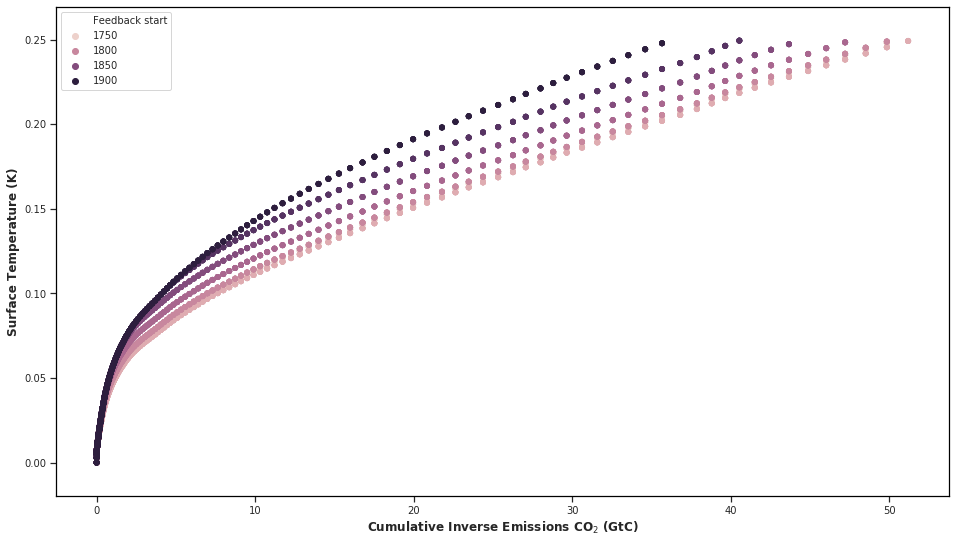

In [14]:
ax = plt.figure(figsize=(16, 9)).add_subplot(111)
hdf = plt_df[
    plt_df["Surface Temperature"] <= 0.25
]
sns.scatterplot(
    data=hdf.copy(),
    x="Cumulative Inverse Emissions CO$_2$ ({})".format(co2_unit),
    y="Surface Temperature (K)",
    hue="Feedback start",
#     s=150,
#     palette=colour_palette,
    linewidth=0,
);

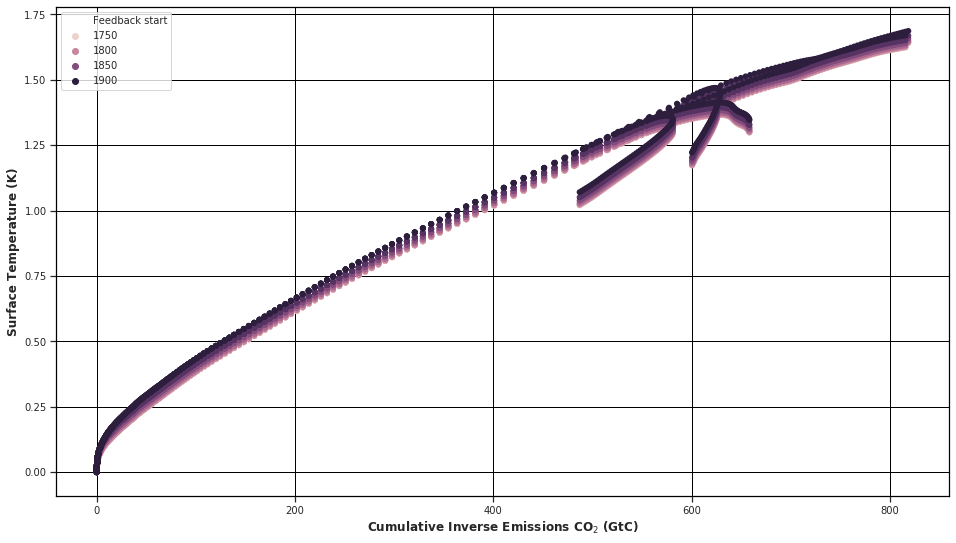

In [15]:
ax = plt.figure(figsize=(16, 9)).add_subplot(111)
sns.scatterplot(
    data=plt_df.copy(),
    x="Cumulative Inverse Emissions CO$_2$ ({})".format(co2_unit),
    y="Surface Temperature (K)",
    hue="Feedback start",
#     s=150,
    ax=ax,
#     palette=colour_palette,
    linewidth=0,
)
ax.grid()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


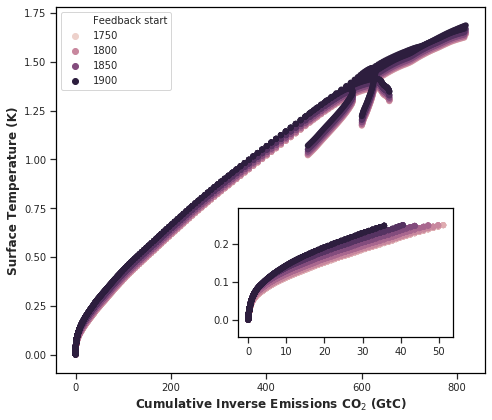

In [16]:
ax = plt.figure().add_subplot(111)

sns.scatterplot(
    data=plt_df,
    x="Cumulative Inverse Emissions CO$_2$ ({})".format(co2_unit),
    y="Surface Temperature (K)",
    hue="Feedback start",
    ax=ax,
#     palette=colour_palette,
    linewidth=0,
);


inset = ax.inset_axes(
    [0.425, 0.1, 0.5, 0.35]
)
hdf = plt_df[
    plt_df["Surface Temperature"] <= 0.25
]
sns.scatterplot(
    data=hdf,
    x="Cumulative Inverse Emissions CO$_2$ ({})".format(co2_unit),
    y="Surface Temperature (K)",
    hue="Feedback start",
    ax=inset,
    legend=False,
#     palette=colour_palette,
    linewidth=0,
);

inset.set_xlabel("")
inset.set_ylabel("")

plt.tight_layout()
plt.savefig(TEMP_FEEDBACK_SWITCH_SENSITIVITY_FIG, transparent=True);

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


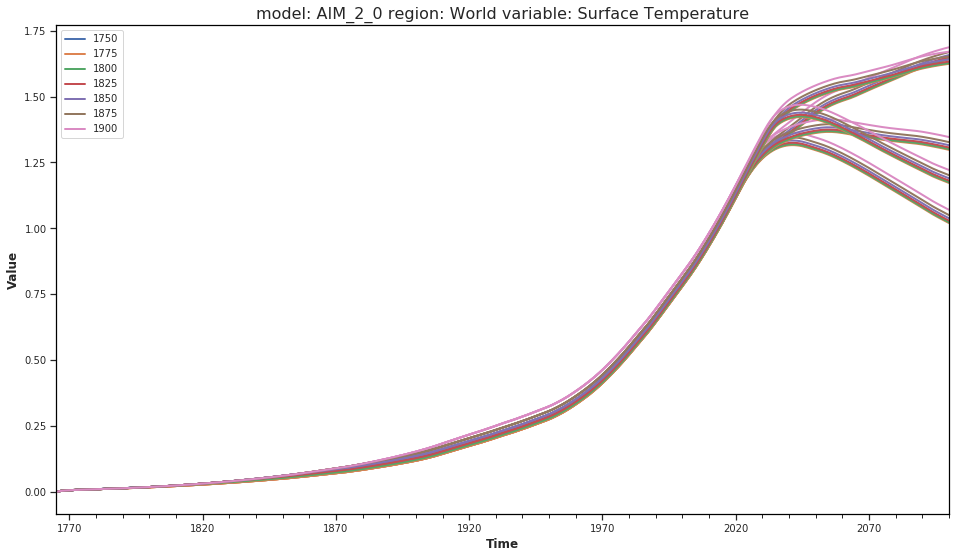

In [17]:
res.filter(
    variable="Surface Temperature",
    region="World",
).line_plot(
    color="co2_tempfeedback_yrstart",
    figsize=(16, 9),
);

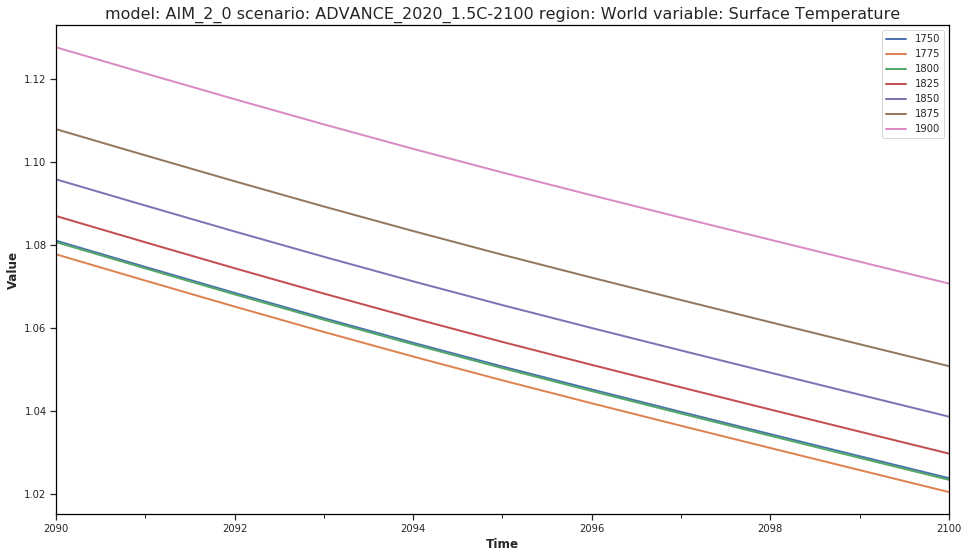

In [18]:
res.filter(
    variable="Surface Temperature",
    region="World",
    year=range(2090, 2101),
    scenario=res["scenario"][0],
    model=res["model"][0],
).line_plot(
    color="co2_tempfeedback_yrstart",
    figsize=(16, 9),
);

In [19]:
ax = res.filter(
    variable="Surface Temperature",
    region="World",
).line_plot(
    color="co2_tempfeedback_yrstart",
    title=False,
    legend=False,
)
ax.set_ylabel("Surface Temperature (K)")
ax.set_xticks([y - 1970 for y in range(1800, 2101, 50)])
ax.set_xticklabels([y for y in range(1800, 2101, 50)])

inset = ax.inset_axes(
    [0.1, 0.5, 0.5, 0.45]
)

res.filter(
    variable="Surface Temperature",
    region="World",
    year=range(2090, 2101),
    scenario=res["scenario"][0],
    model=res["model"][0],
).line_plot(
    color="co2_tempfeedback_yrstart",
    ax=inset,
    title=False,
    legend=False,
)
inset.legend(loc="upper right")
inset.set_xlabel("")
inset.set_ylabel("")
inset.set_xticks([y - 1970 for y in range(2090, 2101, 5)])
inset.set_xticklabels([y for y in range(2090, 2101, 5)])

plt.tight_layout()

Here we show why doing this with concentrations driven is garbage.

In [20]:
rs = {
    "endyear": 2101,
    "out_inverseemis": 1,
    "out_emissions": 1,
    "rf_total_runmodus": "CO2",
    "pf_apply": 1,
    "co2_tempfeedback_yrstart": None,
}
res_conc_driven = []
co2_tempfeedback_yrstarts = range(1750, 1901, 25)
for ys in co2_tempfeedback_yrstarts:
    rs["co2_tempfeedback_yrstart"] = ys
    res_conc_driven.append(run_magicc6_with_scenarios(
        scenarios,
        rs,
        test_run=TEST_RUN,
        vars_to_keep=[
            "Inverse Emissions|CO2|MAGICC Fossil and Industrial",
            "Emissions|CO2|MAGICC Fossil and Industrial",
            "Surface Temperature",
        ]
    ).filter(year=range(1, 2101)))

res_conc_driven = df_append(res_conc_driven)

No co2_switchfromconc2emis_year, is this on purpose?
No co2_fertilization_yrstart, is this on purpose?
| |                                   #               | 4 Elapsed Time: 0:00:03
No co2_switchfromconc2emis_year, is this on purpose?
No co2_fertilization_yrstart, is this on purpose?
| |                                  #                | 4 Elapsed Time: 0:00:03
No co2_switchfromconc2emis_year, is this on purpose?
No co2_fertilization_yrstart, is this on purpose?
| |                                    #              | 4 Elapsed Time: 0:00:03
No co2_switchfromconc2emis_year, is this on purpose?
No co2_fertilization_yrstart, is this on purpose?
| |                                   #               | 4 Elapsed Time: 0:00:03
No co2_switchfromconc2emis_year, is this on purpose?
No co2_fertilization_yrstart, is this on purpose?
| |                                   #               | 4 Elapsed Time: 0:00:03
No co2_switchfromconc2emis_year, is this on purpose?
No co2_fertilization_yrstart, is

In [21]:
res_conc_driven = add_peak_temp_peak_total_cumulative_co2_emissions_to_scmdf(
    res_conc_driven,
    include_permafrost_emissions=False,
    include_inverse_co2_emissions=True,
    include_peaks=False,
)
co2_unit = str(res_conc_driven.filter(variable="Cumulative Inverse Emissions|CO2")["unit"].unique()[0]).replace(" ", "")

In [22]:
plt_df_conc_driven = res_conc_driven.filter(region="World").to_iamdataframe().data
plt_df_conc_driven["year"] = plt_df_conc_driven["time"].apply(lambda x: x.year)
plt_df_conc_driven = plt_df_conc_driven.drop("time", axis="columns")

idx = list(set(plt_df_conc_driven.columns) - {"variable", "value", "unit"})
plt_df_conc_driven = plt_df_conc_driven.pivot_table(values="value", columns=["variable"], index=idx).reset_index()
plt_df_conc_driven["Surface Temperature (K)"] = plt_df_conc_driven["Surface Temperature"]
plt_df_conc_driven["Cumulative Inverse Emissions CO$_2$ ({})".format(co2_unit)] = plt_df_conc_driven["Cumulative Inverse Emissions|CO2"]
plt_df_conc_driven["Temperature feedback start"] = plt_df_conc_driven["co2_tempfeedback_yrstart"]

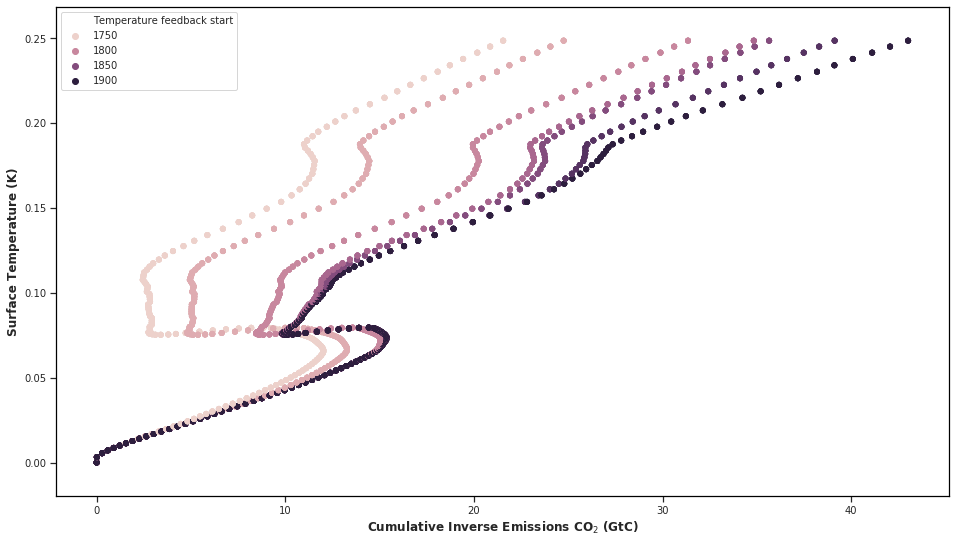

In [23]:
ax = plt.figure(figsize=(16, 9)).add_subplot(111)
hdf_conc_driven = plt_df_conc_driven[
    plt_df_conc_driven["Surface Temperature"] <= 0.25
]
sns.scatterplot(
    data=hdf_conc_driven.copy(),
    x="Cumulative Inverse Emissions CO$_2$ ({})".format(co2_unit),
    y="Surface Temperature (K)",
    hue="Temperature feedback start",
#     s=150,
#     palette=colour_palette,
    linewidth=0,
);

Here we run with the CO2 switch on from start of run or default.

In [24]:
rs = {
    "endyear": 2101,
    "out_inverseemis": 1,
    "out_emissions": 1,
    "rf_total_runmodus": "all",
    "pf_apply": 1,
    "co2_tempfeedback_yrstart": 1750,
    "co2_fertilization_yrstart": 1750,
    "co2_switchfromconc2emis_year": 2010.
}
res_switch = []
res_switch.append(run_magicc6_with_scenarios(
    scenarios,
    rs,
    test_run=TEST_RUN,
    vars_to_keep=[
        "Inverse Emissions|CO2|MAGICC Fossil and Industrial",
        "Emissions|CO2|MAGICC Fossil and Industrial",
        "Surface Temperature",
    ]
).filter(year=range(1, 2101)))

rs["co2_switchfromconc2emis_year"] = 1750
res_switch.append(run_magicc6_with_scenarios(
    scenarios,
    rs,
    test_run=TEST_RUN,
    vars_to_keep=[
        "Inverse Emissions|CO2|MAGICC Fossil and Industrial",
        "Emissions|CO2|MAGICC Fossil and Industrial",
        "Surface Temperature",
    ]
).filter(year=range(1, 2101)))
res_switch = df_append(res_switch)

| |                                   #               | 4 Elapsed Time: 0:00:03
| |                                   #               | 4 Elapsed Time: 0:00:03


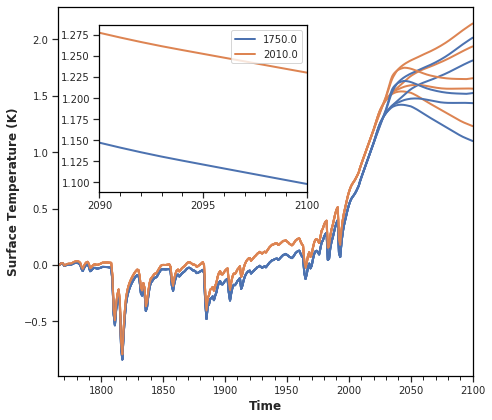

In [25]:
ax = res_switch.filter(
    variable="Surface Temperature",
    region="World",
).line_plot(
    color="co2_switchfromconc2emis_year",
    title=False,
    legend=False,
)
ax.set_ylabel("Surface Temperature (K)")
ax.set_xticks([y - 1970 for y in range(1800, 2101, 50)])
ax.set_xticklabels([y for y in range(1800, 2101, 50)])

inset = ax.inset_axes(
    [0.1, 0.5, 0.5, 0.45]
)

res_switch.filter(
    variable="Surface Temperature",
    region="World",
    year=range(2090, 2101),
    scenario=res["scenario"][0],
    model=res["model"][0],
).line_plot(
    color="co2_switchfromconc2emis_year",
    ax=inset,
    title=False,
    legend=False,
)
inset.legend(loc="upper right")
inset.set_xlabel("")
inset.set_ylabel("")
inset.set_xticks([y - 1970 for y in range(2090, 2101, 5)])
inset.set_xticklabels([y for y in range(2090, 2101, 5)])

plt.tight_layout()